# **Politecnico di Milano**
## *Students: Caravano Andrea, Cantele Alberto*

*A.Y.: 2024/2025*

*Last modified: 24/04/2025*

### Description: Internet of Things: Challenge n. 3 - Theoretical exercise

## Common libraries import and Colab setup

In [1]:
COLAB = False

if COLAB:
    # Colab-only installation of LoRaSim
    ! wget https://www.lancaster.ac.uk/scc/sites/lora/lorasim-20170710.tgz
    ! tar -xvf lorasim-20170710.tgz

    ! sudo apt-get install -y python2 && curl https://bootstrap.pypa.io/pip/2.7/get-pip.py -o get-pip.py && python2 get-pip.py && rm get-pip.py
    ! sudo apt-get install -y python-tk
    ! pip2 install -r 'lorasim/requirements.txt'

    # Update LoRaSim with its modified old version (see notes)
    ! sudo apt-get install -y sed
    ! cp lorasim/loraDir.py lorasim/loraDir-old.py
    ! cp lorasim/loraDirMulBS.py lorasim/loraDirMulBS-old.py
    # Remove lines 116 and 117 (corresponding to the collisions sub-estimation)
    ! sed -i '116,+1d;' lorasim/loraDir-old.py
    # Replace natural logarithms with base-10 logarithm
    ! sed -i 's/math.log10/math.log/g' lorasim/loraDir-old.py
    # Remove lines 107 and 108 (corresponding to the collisions sub-estimation)
    ! sed -i '107,+1d;' lorasim/loraDirMulBS-old.py
    # Replace natural logarithms with base-10 logarithm
    ! sed -i 's/math.log10/math.log/g' lorasim/loraDirMulBS-old.py

    # Import Google Colab's Drive API
    from google.colab import drive

    # Prepare Google Drive mount
    drive.mount("/content/drive", force_remount=True)

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import subprocess
import os
import re
import glob
import shutil

# Question n. 1

## Problem and constants declarations

In [3]:
n_nodes = 50  # nodes
Lambda = 1 / 60  # 1 packet over 1 minute = 60 seconds
# Maximum Spreading Factor allowed for a length L = 60 + 3 = 63 bytes is SF9: limiting L to 51 bytes, being the allowed maximum
# (see https://www.thethingsnetwork.org/airtime-calculator)
spreading_factors = ["SF7", "SF8", "SF9", "SF10", "SF11", "SF12"]
# (from SF10, L = 51 bytes is used, see notes)
t_airtimes = [0.1385, 0.2463, 0.4516, 0.6984, 1.5606, 2.7935]  # seconds

## Success Rates computation

In [4]:
# Success Rate computation is made using a loop to compute every computation with dfferent airtimes and a list to store the results
SR = []
for airtime in t_airtimes:
    SR.append(math.exp(-2 * n_nodes * Lambda * airtime))

## Determine the maximum Spreading Factor matching the Success Rate constraints

In [5]:
# The maximum Spreading Factor matching the Success Rate constraints is determined through a trivial loop iterating on all Success Rate results computed earlier
# Among them, we are looking for the highest one still allowing a matching Success Rate (>= 0.7)
matching_SR = -1
while matching_SR + 1 < len(SR) and SR[matching_SR + 1] > 0.7:
    # Implicit assumption is that the minimum Spreading Factor matches the constraints
    matching_SR += 1

best_SF = spreading_factors[matching_SR]
print(
    f"The resulting maximum Spreading Factor with a Success Rate matching the constraints (>= 0.7) is: {best_SF}"
)

The resulting maximum Spreading Factor with a Success Rate matching the constraints (>= 0.7) is: SF7


# Question n. 3

## Simulation primitives

In [6]:
# Simulation output directories (see notes)
UPDATED_VARIANT_DIR = "updated"
OLD_VARIANT_DIR = "old"


def simulate(n_nodes, tx_rate, exp, duration, collisions=True, old=False):
    env = os.environ.copy()
    env["MPLBACKEND"] = "Agg"

    # Old version discriminant (see notes)
    if old:
        old = "-old"
    else:
        old = ""

    # Final output directory (for simulation outputs)
    output_directory = OLD_VARIANT_DIR if old else UPDATED_VARIANT_DIR

    # Use subprocess.run to execute the command and capture output
    result = subprocess.run(
        [
            "python2",
            (
                f"/lorasim/loraDir{old}.py"
                if not COLAB
                else f"{os.getcwd()}/lorasim/loraDir{old}.py"
            ),
            str(int(n_nodes)),
            str(int(tx_rate)),
            str(int(exp)),
            str(int(duration)),
            str(int(collisions)),
        ],
        cwd=f"{os.getcwd()}/{output_directory}",
        env=env,
        # The simulator produces a heavily verbose output: it must be discarded.
        # Otherwise, for higher configurations, it will fill out the machine's memory!
        # The standard simulator's output is discarded, while the errors stream is kept.
        stdout=subprocess.DEVNULL,
        stderr=subprocess.STDOUT,
        # capture_output=True,
        # text=True,  # Capture output as text
    )

    # Print the output
    # print(result.stdout)
    # print(result.stderr)


def simulate_multisink(
    n_nodes, tx_rate, exp, duration, base_stations, collisions=True, old=False
):
    env = os.environ.copy()
    env["MPLBACKEND"] = "Agg"

    # Old version discriminant (see notes)
    if old:
        old = "-old"
    else:
        old = ""

    # Final output directory (for simulation outputs)
    output_directory = OLD_VARIANT_DIR if old else UPDATED_VARIANT_DIR

    # Use subprocess.run to execute the command and capture output
    result = subprocess.run(
        [
            "python2",
            (
                f"/lorasim/loraDirMulBS{old}.py"
                if not COLAB
                else f"{os.getcwd()}/lorasim/loraDirMulBS{old}.py"
            ),
            str(int(n_nodes)),
            str(int(tx_rate)),
            str(int(exp)),
            str(int(duration)),
            str(int(base_stations)),
            str(int(collisions)),
        ],
        cwd=f"{os.getcwd()}/{output_directory}",
        env=env,
        # The simulator produces a heavily verbose output: it must be discarded.
        # Otherwise, for higher configurations, it will fill out the machine's memory!
        # The standard simulator's output is discarded, while the errors stream is kept.
        stdout=subprocess.DEVNULL,
        stderr=subprocess.STDOUT,
        # capture_output=True,
        # text=True,  # Capture output as text
    )

    # Print the output
    # print(result.stdout)
    # print(result.stderr)


# Der in aloha defined as S/G = e^(-2G)
def aloha_der(n_nodes, t):
    rate = 1e-6
    return math.exp(-2 * n_nodes * rate * t)

## Environment cleanup and management primitives

In [7]:
def reformat_multisink(directory="."):
    # Regular expression that matches files ending in BS{number}.dat
    pattern_file = re.compile(r".*BS\d+\.dat$")

    # Get all .dat files
    dat_files = glob.glob(os.path.join(directory, "*.dat"))

    # Filter for the matching ones
    files = [f for f in dat_files if pattern_file.match(f)]

    for path in files:
        # Read contents and locally store them
        with open(path, "r") as file:
            lines = file.readlines()

        # Update status flag
        status = False

        for i, line in enumerate(lines):
            if line.startswith("# "):
                # Remove the # extra space (for the format alignment)
                lines[i] = "#" + line[2:]
                status = True

        # Update file contents with the reformatted one
        if status:
            with open(path, "w") as file:
                file.writelines(lines)


def simulation_outputs(directory="."):
    # Get all .dat files
    dat_files = glob.glob(os.path.join(directory, "*.dat"))
    # And also computation outputs from the multi-basestation case
    bs_file = glob.glob(os.path.join(directory, "basestation.txt"))
    nodes_file = glob.glob(os.path.join(directory, "nodes.txt"))
    # And finally output figures
    output_figures = glob.glob(os.path.join(directory, "figure*.png"))
    return dat_files + bs_file + nodes_file + output_figures


def cleanup_environment(directory="."):
    for f in simulation_outputs(directory):
        os.remove(f)


# Automatically invoke cleanup of the environment
cleanup_environment(f"./{UPDATED_VARIANT_DIR}")
cleanup_environment(f"./{OLD_VARIANT_DIR}")

try:
    os.mkdir(f"./{UPDATED_VARIANT_DIR}")
    os.mkdir(f"./{OLD_VARIANT_DIR}")
except:
    pass

## Simulation - Figure 5

In [8]:
# Problem data
# one packet of length L every 16,7 min = 16.7 * 60 * 1000 ms
transmission_rate = 16.7 * 60 * 1000
# 58 days simulation (see notes)
duration = 58 * 24 * 60 * 60 * 1000
# Enable the full collisions tracing model (see notes)
full_collision_model = True

n_nodes = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600]

# Experiments set
experiments = [4, 3, 5]

# Iterate on all the interesting node configurations
for nodes in n_nodes:
    print(
        f"Simulating experiments n. {experiments[0]}, {experiments[1]} and {experiments[2]} on {nodes} nodes"
    )
    for exp in experiments:
        # Updated variant
        simulate(nodes, transmission_rate, exp, duration, full_collision_model, False)
        # Old variant
        simulate(nodes, transmission_rate, exp, duration, full_collision_model, True)

Simulating experiments n. 4, 3 and 5 on 50 nodes
Simulating experiments n. 4, 3 and 5 on 100 nodes
Simulating experiments n. 4, 3 and 5 on 200 nodes
Simulating experiments n. 4, 3 and 5 on 300 nodes
Simulating experiments n. 4, 3 and 5 on 400 nodes
Simulating experiments n. 4, 3 and 5 on 500 nodes
Simulating experiments n. 4, 3 and 5 on 600 nodes
Simulating experiments n. 4, 3 and 5 on 700 nodes
Simulating experiments n. 4, 3 and 5 on 800 nodes
Simulating experiments n. 4, 3 and 5 on 900 nodes
Simulating experiments n. 4, 3 and 5 on 1000 nodes
Simulating experiments n. 4, 3 and 5 on 1200 nodes
Simulating experiments n. 4, 3 and 5 on 1400 nodes
Simulating experiments n. 4, 3 and 5 on 1600 nodes


## Extract simulation results files

In [9]:
data = []
data_old = []
for exp in experiments:
    data.append(pd.read_csv(f"{UPDATED_VARIANT_DIR}/exp{exp}.dat", sep=" "))
    data_old.append(pd.read_csv(f"{OLD_VARIANT_DIR}/exp{exp}.dat", sep=" "))

## Data preparation

In [10]:
for d in data:
    d["der"] = (d["nrTransmissions"] - d["nrCollisions"]) / d["nrTransmissions"]

for d in data_old:
    d["der"] = (d["nrTransmissions"] - d["nrCollisions"]) / d["nrTransmissions"]

labels = [
    "SN³ (Static)",
    "SN⁴ (Dynamic, min airtime)",
    "SN⁵ (Dynamic, min airtime & TP)",
]

markers = ["s", "o", "*"]

# Explicit assertion: datasets and their labels are coherent in size
assert len(data) == len(data_old)
assert len(data) == len(labels)

# Example of the resulting data
data[0].head()
data_old[0].head()

,#nrNodes,nrCollisions,nrTransmissions,OverallEnergy,der
0,50,10421,250278,43572.494795,0.958362
1,100,39405,498710,86823.607665,0.920986
2,200,159307,1000254,174140.604482,0.840733
3,300,343913,1501045,261326.506721,0.770884
4,400,574643,1999832,348163.519807,0.712654


## Data plot, updated variant

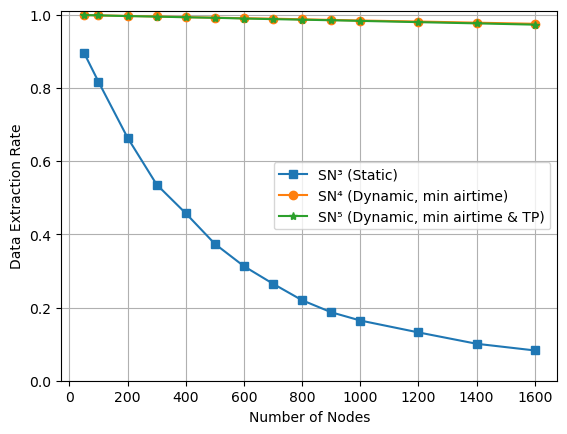

In [11]:
plt.figure(dpi=300)  # higher resolution plot
for i in range(0, len(data)):
    # Plot labelled data sets: Number of nodes on the X axis and Data Extraction Rate on the Y axis
    plt.plot(data[i]["#nrNodes"], data[i]["der"], marker=markers[i], label=labels[i])
plt.xlabel("Number of Nodes")
plt.ylabel("Data Extraction Rate")
# Valid Y range is from 0 to 1 (an extra is included for representation spacing)
plt.ylim(0, 1 + 0.01)
plt.legend()
plt.grid()
plt.savefig(f"{UPDATED_VARIANT_DIR}/figure5.png")
plt.show()

## Data plot, old variant

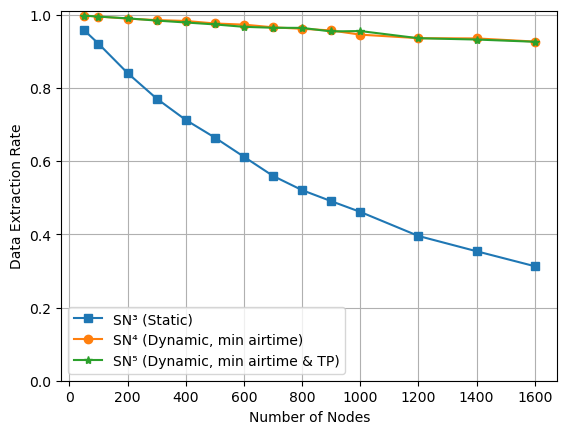

In [12]:
plt.figure(dpi=300)  # higher resolution plot
for i in range(0, len(data_old)):
    # Plot labelled data sets: Number of nodes on the X axis and Data Extraction Rate on the Y axis
    plt.plot(
        data_old[i]["#nrNodes"], data_old[i]["der"], marker=markers[i], label=labels[i]
    )
plt.xlabel("Number of Nodes")
plt.ylabel("Data Extraction Rate")
# Valid Y range is from 0 to 1 (an extra is included for representation spacing)
plt.ylim(0, 1 + 0.01)
plt.legend()
plt.grid()
plt.savefig(f"{OLD_VARIANT_DIR}/figure5.png")
plt.show()

## Simulation - Figure 7

In [13]:
# Problem data
# one packet of length L every 16,7 min = 16.7 * 60 * 1000 ms
transmission_rate = 16.7 * 60 * 1000
n_sinks = [1, 2, 3, 4, 8, 24]  # base stations (sinks)
# 58 days simulation (see notes)
duration = 58 * 24 * 60 * 60 * 1000
# Enable the full collisions tracing model (see notes)
full_collision_model = True

n_nodes = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600]

# Experiments set consists only of a common setting (see notes)
experiment = 0

# Iterate on all the interesting node (and sink) configurations
for sink in n_sinks:
    for nodes in n_nodes:
        print(
            f"Simulating experiment n. {experiment} on {nodes} nodes and {sink} sinks"
        )
        # Updated variant
        simulate_multisink(
            nodes,
            transmission_rate,
            experiment,
            duration,
            sink,
            full_collision_model,
            False,
        )
        # Old variant
        simulate_multisink(
            nodes,
            transmission_rate,
            experiment,
            duration,
            sink,
            full_collision_model,
            True,
        )

# Reformat results for the plot sub-computations, for both the updated and old cases
reformat_multisink(f"./{UPDATED_VARIANT_DIR}")
reformat_multisink(f"./{OLD_VARIANT_DIR}")

Simulating experiment n. 0 on 50 nodes and 1 sinks
Simulating experiment n. 0 on 100 nodes and 1 sinks
Simulating experiment n. 0 on 200 nodes and 1 sinks
Simulating experiment n. 0 on 300 nodes and 1 sinks
Simulating experiment n. 0 on 400 nodes and 1 sinks
Simulating experiment n. 0 on 500 nodes and 1 sinks
Simulating experiment n. 0 on 600 nodes and 1 sinks
Simulating experiment n. 0 on 700 nodes and 1 sinks
Simulating experiment n. 0 on 800 nodes and 1 sinks
Simulating experiment n. 0 on 900 nodes and 1 sinks
Simulating experiment n. 0 on 1000 nodes and 1 sinks
Simulating experiment n. 0 on 1200 nodes and 1 sinks
Simulating experiment n. 0 on 1400 nodes and 1 sinks
Simulating experiment n. 0 on 1600 nodes and 1 sinks
Simulating experiment n. 0 on 50 nodes and 2 sinks
Simulating experiment n. 0 on 100 nodes and 2 sinks
Simulating experiment n. 0 on 200 nodes and 2 sinks
Simulating experiment n. 0 on 300 nodes and 2 sinks
Simulating experiment n. 0 on 400 nodes and 2 sinks
Simulating

## Extract simulation results files

In [14]:
data = []
data_old = []
for sink in n_sinks:
    data.append(
        pd.read_csv(f"{UPDATED_VARIANT_DIR}/exp{experiment}BS{sink}.dat", sep=" ")
    )
    data_old.append(
        pd.read_csv(f"{OLD_VARIANT_DIR}/exp{experiment}BS{sink}.dat", sep=" ")
    )

## Data preparation

In [15]:
# Each sink configuration has its own dataset
labels = [f"{s} sinks" for s in n_sinks]

markers = ["+", "o", "*", "s", "D", "h"]

# Explicit assertion: datasets and their labels are coherent in size
assert len(data) == len(data_old)
assert len(data) == len(labels)

# Example of the resulting data
data[0].head()
data_old[0].head()

,#nrNodes,DER
0,50,0.948365
1,100,0.898525
2,200,0.803574
3,300,0.725316
4,400,0.660302


## Data plot, updated variant

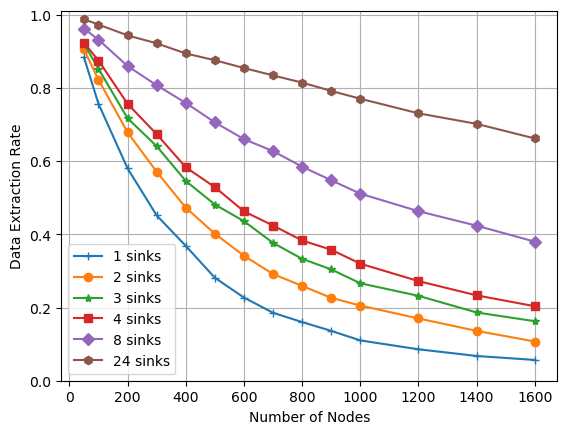

In [16]:
plt.figure(dpi=300)  # higher resolution plot
for i in range(0, len(data)):
    # Plot labelled data sets: Number of nodes on the X axis and Data Extraction Rate on the Y axis
    plt.plot(data[i]["#nrNodes"], data[i]["DER"], marker=markers[i], label=labels[i])
plt.xlabel("Number of Nodes")
plt.ylabel("Data Extraction Rate")
# Valid Y range is from 0 to 1 (an extra is included for representation spacing)
plt.ylim(0, 1 + 0.01)
plt.legend()
plt.grid()
plt.savefig(f"{UPDATED_VARIANT_DIR}/figure7.png")
plt.show()

## Data plot, old variant

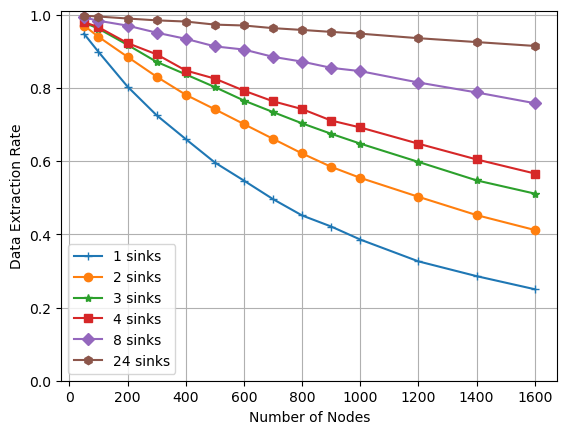

In [17]:
plt.figure(dpi=300)  # higher resolution plot
for i in range(0, len(data_old)):
    # Plot labelled data sets: Number of nodes on the X axis and Data Extraction Rate on the Y axis
    plt.plot(data_old[i]["#nrNodes"], data_old[i]["DER"], marker=markers[i], label=labels[i])
plt.xlabel("Number of Nodes")
plt.ylabel("Data Extraction Rate")
# Valid Y range is from 0 to 1 (an extra is included for representation spacing)
plt.ylim(0, 1 + 0.01)
plt.legend()
plt.grid()
plt.savefig(f"{OLD_VARIANT_DIR}/figure7.png")
plt.show()

## Colab environment: upload simulation outputs on Google Drive

In [18]:
DRIVE_DESTINATION_FOLDER = "/content/drive/My Drive/challenge3"
if COLAB:
    # Prepare Google Drive mount
    drive.mount("/content/drive", force_remount=True)

    output_dirs = simulation_outputs(f"./{UPDATED_VARIANT_DIR}")
    output_dirs += simulation_outputs(f"./{OLD_VARIANT_DIR}")

    for f in output_dirs:
        shutil.copy2(f, DRIVE_DESTINATION_FOLDER + f[1 : len(f)])

    # Flush updated content
    drive.flush_and_unmount()